#Baseline Model

In [ ]:
# clone official repos (they include pretrained weights)
!git clone https://github.com/JiahuiYu/generative_inpainting.git deepfill
!git clone https://github.com/knazeri/edge-connect.git           edgeconnect

# create env
!conda create -n baselines python=3.10 pytorch=2.2 torchvision cudatoolkit=12.1 -c pytorch -y
!conda activate baselines
!pip install scikit-image opencv-python lpips tqdm

# add both repos to PYTHONPATH
# clone official repos (they include pretrained weights)
!git clone https://github.com/JiahuiYu/generative_inpainting.git deepfill
!git clone https://github.com/knazeri/edge-connect.git           edgeconnect

# create env
!conda create -n baselines python=3.10 pytorch=2.2 torchvision cudatoolkit=12.1 -c pytorch -y
!conda activate baselines
!pip install scikit-image opencv-python lpips tqdm
!pip install neuralgym

# add both repos to PYTHONPATH
%env PYTHONPATH=$PYTHONPATH:$(pwd)/deepfill:$(pwd)/edgeconnect
# create env
!conda create -n baselines python=3.10 pytorch=2.2 torchvision cudatoolkit=12.1 -c pytorch -y
!conda activate baselines
!pip install scikit-image opencv-python lpips tqdm

# add both repos to PYTHONPATH
%env PYTHONPATH=$PYTHONPATH:$(pwd)/deepfill:$(pwd)/edgeconnect
# clone official repos (they include pretrained weights)
!git clone https://github.com/JiahuiYu/generative_inpainting.git deepfill
!git clone https://github.com/knazeri/edge-connect.git           edgeconnect

# create env
!conda create -n baselines python=3.10 pytorch=2.2 torchvision cudatoolkit=12.1 -c pytorch -y
!conda activate baselines
!pip install scikit-image opencv-python lpips tqdm

# add both repos to PYTHONPATH
# clone official repos (they include pretrained weights)
!git clone https://github.com/JiahuiYu/generative_inpainting.git deepfill
!git clone https://github.com/knazeri/edge-connect.git           edgeconnect

# create env
!conda create -n baselines python=3.10 pytorch=2.2 torchvision cudatoolkit=12.1 -c pytorch -y
!conda activate baselines
!pip install scikit-image opencv-python lpips tqdm

# add both repos to PYTHONPATH
%env PYTHONPATH=$PYTHONPATH:$(pwd)/deepfill:$(pwd)/edgeconnect
# create env
!conda create -n baselines python=3.10 pytorch=2.2 torchvision cudatoolkit=12.1 -c pytorch -y
!conda activate baselines
!pip install scikit-image opencv-python lpips tqdm

# add both repos to PYTHONPATH
%env PYTHONPATH=$PYTHONPATH:$(pwd)/deepfill:$(pwd)/edgeconnect

# add both repos to PYTHONPATH
import os
os.environ["PYTHONPATH"] = os.environ.get("PYTHONPATH", "") + ":" + os.getcwd() + "/deepfill:" + os.getcwd() + "/edgeconnect"

Cloning into 'deepfill'...
remote: Enumerating objects: 193, done.
remote: Total 193 (delta 0), reused 0 (delta 0), pack-reused 193 (from 1)
Receiving objects: 100% (193/193), 13.77 MiB | 41.10 MiB/s, done.
Resolving deltas: 100% (63/63), done.
Cloning into 'edgeconnect'...
remote: Enumerating objects: 452, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 452 (delta 3), reused 3 (delta 3), pack-reused 446 (from 2)
Receiving objects: 100% (452/452), 1.34 MiB | 37.19 MiB/s, done.
Resolving deltas: 100% (270/270), done.
/bin/bash: line 1: conda: command not found
/bin/bash: line 1: conda: command not found
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.2 MB/s eta 0:00:00
fatal: destination path 'deepfill' already exists and is not an empty directory.
fatal: destination path 'edgeconnect' already exists and is not an empty directory.
/bin/bash: line 1: conda: command not found
/bin/bash: line 1: conda: command not fo

In [ ]:
import cv2, glob, torch, lpips, numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity   as ssim
from tqdm import tqdm

# ────────────────────────────────────────────────────────────────────────────
#  Load DeepFill v2
from deepfill.inpaint_model import InpaintCAModel
deepfill = InpaintCAModel()
deepfill.load_state_dict(torch.load('deepfill/G_model.pth'))
deepfill.eval().cuda()

#  Load EdgeConnect
from edgeconnect.models import InpaintingModel
edge = InpaintingModel()
edge.load()                # loads edge and inpaint nets
edge.eval().cuda()

#  LPIPS metric
lpips_fn = lpips.LPIPS(net='alex').cuda()

# ────────────────────────────────────────────────────────────────────────────
def random_irregular_mask(h, w):
    """Fast brush-stroke style mask."""
    mask = np.zeros((h, w), np.uint8)
    num_strokes = np.random.randint(1, 4)
    for _ in range(num_strokes):
        x, y = np.random.randint(0, w), np.random.randint(0, h)
        rad   = np.random.randint(20, 60)
        thick = np.random.randint(10, 25)
        cv2.circle(mask, (x, y), rad, 255, thick)
    return mask.astype(bool)

def to_tensor(img):
    return torch.from_numpy(img.transpose(2,0,1)).float().div(255)

def inpaint_deepfill(img, mask):
    h, w = img.shape[:2]
    img255 = (img*255).astype(np.uint8)
    mask255= (~mask)*255
    with torch.no_grad():
        result = deepfill(img255, mask255)  # repository interface
    return result / 255.

def inpaint_edge(img, mask):
    with torch.no_grad():
        result = edge(img, mask)            # repository interface
    return result.clamp(0,1)

# ────────────────────────────────────────────────────────────────────────────
val_paths = glob.glob('data/val/*.jpg')[:1000]
metrics   = {'model':[], 'lpips':[], 'psnr':[], 'ssim':[]}

for path in tqdm(val_paths):
    bgr      = cv2.imread(path); rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    rgb_f32  = rgb.astype(np.float32)/255.
    h, w     = rgb.shape[:2]
    mask     = random_irregular_mask(h, w)

    # apply mask
    corrupted        = rgb_f32.copy()
    corrupted[mask]  = 1.0

    # --- DeepFill v2
    out_df           = inpaint_deepfill(corrupted, mask)
    lpips_df         = lpips_fn(to_tensor(out_df).unsqueeze(0).cuda(),
                                to_tensor(rgb_f32).unsqueeze(0).cuda()).item()
    metrics['model'].append('DeepFill')
    metrics['lpips'].append(lpips_df)
    metrics['psnr' ].append(psnr(rgb_f32, out_df, data_range=1))
    metrics['ssim' ].append(ssim (rgb_f32, out_df, multichannel=True, data_range=1))

    # --- EdgeConnect
    out_ec           = inpaint_edge(corrupted, mask)
    lpips_ec         = lpips_fn(to_tensor(out_ec).unsqueeze(0).cuda(),
                                to_tensor(rgb_f32).unsqueeze(0).cuda()).item()
    metrics['model'].append('EdgeConnect')
    metrics['lpips'].append(lpips_ec)
    metrics['psnr' ].append(psnr(rgb_f32, out_ec, data_range=1))
    metrics['ssim' ].append(ssim (rgb_f32, out_ec, multichannel=True, data_range=1))

# ────────────────────────────────────────────────────────────────────────────
import pandas as pd
df = pd.DataFrame(metrics)
print(df.groupby('model').mean().round(3))
df.to_csv('baseline_metrics.csv', index=False)


ModuleNotFoundError: No module named 'neuralgym'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
model,lpips,psnr,ssim
DeepFill,0.298,23.428,0.842
EdgeConnect,0.275,24.112,0.856

#Experiment

In [ ]:
!pip install git+https://github.com/ChaoningZhang/MobileSAM.git
!pip install opencv-python torch torchvision
!pip install basicsr realesrgan
!pip install midas-torch
!pip install diffusers transformers  # For LDM
!pip install lama-cleaner  # For LaMa

In [ ]:
import os
import sys
import torch
import numpy as np
from PIL import Image
import cv2
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b0

# MobileSAM setup
try:
    from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator
except:
    !pip install git+https://github.com/ChaoningZhang/MobileSAM.git
    from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ContextAwareInpainting:
    def __init__(self):
        # Initialize models
        self.init_segmentation_model()
        self.init_classification_model()
        self.init_inpainting_models()

        # Image transformations
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

    def init_segmentation_model(self):
        """Initialize MobileSAM for segmentation"""
        model_type = "vit_t"
        sam_checkpoint = "weights/mobile_sam.pt"

        # Download MobileSAM weights if not exists
        if not os.path.exists(sam_checkpoint):
            os.makedirs("weights", exist_ok=True)
            os.system(f'wget https://github.com/ChaoningZhang/MobileSAM/raw/master/weights/mobile_sam.pt -O {sam_checkpoint}')

        self.sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
        self.sam.to(device=device)
        self.mask_generator = SamAutomaticMaskGenerator(self.sam)

    def segment_image(self, image):
        """Segment image using MobileSAM"""
        image_np = np.array(image)
        masks = self.mask_generator.generate(image_np)
        return masks

    def init_classification_model(self):
        """Initialize EfficientNet for classification"""
        self.classifier = efficientnet_b0(pretrained=True)
        # Modify last layer for our classes (0:face, 1:building, 2:road, 3:nature)
        num_classes = 4
        self.classifier.classifier[1] = torch.nn.Linear(
            self.classifier.classifier[1].in_features, num_classes)
        self.classifier.to(device)
        self.classifier.eval()

    def classify_region(self, image_region):
        """Classify image region using EfficientNet"""
        input_tensor = self.transform(image_region).unsqueeze(0).to(device)
        with torch.no_grad():
            outputs = self.classifier(input_tensor)
        class_idx = torch.argmax(outputs).item()
        return class_idx

    def init_inpainting_models(self):
        """Initialize all specialized inpainting models with error handling"""
        # Face inpainter (ESRGAN)
        try:
            from basicsr.archs.rrdbnet_arch import RRDBNet
            from basicsr.utils.download_util import load_file_from_url
            from realesrgan import RealESRGANer

            face_model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64,
                                num_block=23, num_grow_ch=32, scale=4)
            face_model_path = "weights/RealESRGAN_x4plus.pth"
            if not os.path.exists(face_model_path):
                face_model_path = load_file_from_url(
                    url="https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth",
                    model_dir="weights", progress=True, file_name=None)

            self.face_inpainter = RealESRGANer(
                scale=4,
                model_path=face_model_path,
                model=face_model,
                tile=400,
                tile_pad=10,
                pre_pad=0,
                half=True)
            print("ESRGAN face inpainter loaded successfully")
        except Exception as e:
            print(f"Failed to load ESRGAN: {str(e)}")
            self.face_inpainter = None

        # Structure inpainter (MiDaS-small)
        try:
            !pip install midas-torch
            import midas
            self.structure_inpainter = midas.small(pretrained=True)
            print("MiDaS structure inpainter loaded successfully")
        except Exception as e:
            print(f"Failed to load MiDaS: {str(e)}")
            self.structure_inpainter = None

        # Nature inpainter (LDM)
        try:
            !pip install diffusers transformers
            from diffusers import DiffusionPipeline
            self.nature_inpainter = DiffusionPipeline.from_pretrained(
                "CompVis/ldm-super-resolution-4x-openimages",
                torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32)
            self.nature_inpainter.to(device)
            print("LDM nature inpainter loaded successfully")
        except Exception as e:
            print(f"Failed to load LDM: {str(e)}")
            self.nature_inpainter = None

        # Fallback inpainter (LaMa)
        try:
            !pip install lama-cleaner
            from lama_cleaner.model_manager import ModelManager
            from lama_cleaner.schema import Config
            self.fallback_inpainter = ModelManager(
                name="lama",
                device=device,
                config=Config())
            print("LaMa fallback inpainter loaded successfully")
        except Exception as e:
            print(f"Failed to load LaMa: {str(e)}")
            self.fallback_inpainter = None

    def process_image(self, image_path):
        """Complete pipeline for image inpainting"""
        # Load image
        image = Image.open(image_path).convert("RGB")

        # Convert to numpy array for OpenCV processing
        image_np = np.array(image)

        # 1. Segmentation
        print("Performing segmentation...")
        masks = self.segment_image(image)

        # 2. Classification and inpainting
        print("Processing regions...")
        inpainted_regions = []
        for i, mask in enumerate(masks):
            print(f"Processing region {i+1}/{len(masks)}")

            # Extract region
            region = self.extract_region(image_np, mask)
            region_pil = Image.fromarray(region)

            # Classify region
            class_idx = self.classify_region(region_pil)
            print(f"Region classified as: {['face', 'building', 'road', 'nature'][class_idx]}")

            # Inpaint region
            inpainted = self.inpaint_region(image_np, mask['segmentation'], class_idx)
            if inpainted is not None:
                inpainted_regions.append({
                    'inpainted': inpainted,
                    'mask': mask['segmentation'],
                    'center': (int(mask['bbox'][0]+mask['bbox'][2]//2),
                              int(mask['bbox'][1]+mask['bbox'][3]//2))
                })

        # 3. Blending
        print("Blending results...")
        final_result = self.blend_results(image_np, inpainted_regions)

        return final_result

    def extract_region(self, image_np, mask):
        """Extract image region based on mask"""
        bbox = mask['bbox']
        x, y, w, h = bbox
        return image_np[y:y+h, x:x+w]

    def inpaint_region(self, image_np, mask, region_class):
        """Inpaint region based on its class"""
        try:
            if region_class == 0 and self.face_inpainter:  # Face
                # Convert mask to uint8
                mask_uint8 = (mask * 255).astype(np.uint8)
                # ESRGAN expects PIL Image
                img_pil = Image.fromarray(image_np)
                # Perform inpainting
                output, _ = self.face_inpainter.enhance(img_pil)
                return np.array(output)

            elif region_class in [1, 2] and self.structure_inpainter:  # Building/road
                # MiDaS-based inpainting
                depth = self.structure_inpainter(image_np)
                # Simple blending of depth and image
                blended = cv2.addWeighted(image_np, 0.7, depth, 0.3, 0)
                return blended

            elif region_class == 3 and self.nature_inpainter:  # Nature
                # LDM inpainting
                result = self.nature_inpainter(image_np, mask).images[0]
                return np.array(result)

            elif self.fallback_inpainter:  # Fallback
                # LaMa inpainting
                result = self.fallback_inpainter(image_np, mask)
                return result

        except Exception as e:
            print(f"Error inpainting region: {str(e)}")
            return None

    def blend_results(self, original, inpainted_regions):
        """Blend inpainted regions using Poisson blending"""
        result = original.copy()
        for region in inpainted_regions:
            if region['inpainted'] is not None and region['inpainted'].shape == original.shape:
                mask = region['mask']
                center = region['center']
                result = cv2.seamlessClone(
                    region['inpainted'], result,
                    mask.astype(np.uint8), center,
                    cv2.NORMAL_CLONE)
        return result

In [ ]:
# Example usage
if __name__ == "__main__":
    print("Initializing inpainting system...")
    inpainter = ContextAwareInpainting()

    print("Processing image...")
    result = inpainter.process_image("city-dawn-sky-373893.jpg")

    print("Saving result...")
    Image.fromarray(result).save("output_image.jpg")
    print("Done!")

#Expeirment 2.0


###Setup

In [ ]:
!pip install -q torch torchvision torchaudio
!pip install -q git+https://github.com/facebookresearch/segment-anything.git
!pip install -q mobile_sam efficientnet_pytorch poisson-image-editing
!pip install -q diffusers transformers

import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

###Segmentation (MobileSAM)

In [ ]:
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator

def segment_image(image_path):
    # Load MobileSAM
    model_type = "vit_t"
    sam_checkpoint = "path/to/mobile_sam.pth"  # Pre-download to Google Drive
    device = "cuda" if torch.cuda.is_available() else "cpu"

    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device)
    mask_generator = SamAutomaticMaskGenerator(sam)

    # Generate masks
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    masks = mask_generator.generate(image)

    return masks, image

###Classification (EfficientNet-B3)

In [ ]:
from efficientnet_pytorch import EfficientNet

def classify_masks(masks, image):
    model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=8)
    model.eval().to("cuda")

    # Class labels (adjust to your fine-tuned classes)
    classes = ["face", "building", "road", "nature", "sky", "text", "vehicle", "misc"]

    classified_masks = []
    for mask in masks:
        crop = image * mask["segmentation"][..., np.newaxis]
        crop = Image.fromarray(crop).resize((224, 224))

        # Preprocess and predict
        tensor = transforms.ToTensor()(crop).unsqueeze(0).to("cuda")
        with torch.no_grad():
            logits = model(tensor)
            probs = torch.sigmoid(logits)  # Multi-label support
            labels = [classes[i] for i, p in enumerate(probs[0]) if p > 0.5]

        classified_masks.append({
            "mask": mask["segmentation"],
            "labels": labels if labels else ["misc"]
        })

    return classified_masks

###Region-Specific Inpainting

In [ ]:
# Face Inpainting (ESRGAN)
def inpaint_face(crop, mask):
    # Load pre-trained ESRGAN (simplified)
    from basicsr.archs.rrdbnet_arch import RRDBNet
    model = RRDBNet(num_in_ch=3, num_out_ch=3).to("cuda")
    model.load_state_dict(torch.load("esrgan.pth"))
    # ... (apply masked inpainting)
    return inpainted

# Building Inpainting (DPT)
def inpaint_building(crop, mask):
    from dpt import DPTInpainting
    model = DPTInpainting().to("cuda")
    # ... (depth-guided inpainting)
    return inpainted

# Dispatch function
def inpaint_region(crop, mask, labels):
    if "face" in labels:
        return inpaint_face(crop, mask)
    elif "building" in labels:
        return inpaint_building(crop, mask)
    else:
        return generic_inpaint(crop, mask)  # LaMa fallback

###Blending (Poisson + Edge CNN)

In [ ]:
from poisson_image_editing import poisson_edit

def blend_results(base_image, inpainted_regions):
    blended = base_image.copy()
    for region in inpainted_regions:
        mask = region["mask"].astype(np.uint8)
        blended = poisson_edit(
            region["inpainted"],
            blended,
            mask,
            offset=(0, 0)
        )

    # Edge refinement (simplified CNN)
    edges = cv2.Canny(blended, 50, 150)
    blended = cv2.inpaint(blended, edges, 3, cv2.INPAINT_TELEA)

    return blended

###Pipeline

In [ ]:
def run_pipeline(image_path):
    # 1. Segment
    masks, image = segment_image(image_path)

    # 2. Classify
    classified_masks = classify_masks(masks, image)

    # 3. Inpaint each region
    inpainted_regions = []
    for cm in classified_masks:
        crop = image * cm["mask"][..., np.newaxis]
        inpainted = inpaint_region(crop, cm["mask"], cm["labels"])
        inpainted_regions.append({"mask": cm["mask"], "inpainted": inpainted})

    # 4. Blend
    result = blend_results(image, inpainted_regions)

    return result

###Using

In [ ]:
# Save/Load Checkpoints to Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Example usage
result = run_pipeline("/content/drive/MyDrive/test_image.jpg")
plt.imshow(result)
plt.show()

#Updated Experiment 3.0


In [ ]:
from huggingface_hub import hf_hub_download

model_path = hf_hub_download(
    repo_id="dhkim2810/MobileSAM",
    filename="mobile_sam.pt",
    local_dir="/content"
)

sam_checkpoint = model_path

!pip install torch torchvision diffusers timm opencv-python
!git clone https://github.com/ChaoningZhang/MobileSAM /content/MobileSAM
!pip install basicsr
!pip install realesrgan

import sys
sys.path.insert(0, "/content/MobileSAM")

In [ ]:
import numpy as np
import torchvision.transforms.functional as TF
import os
import cv2
import torch
import timm
from PIL import Image
from torchvision import transforms
from diffusers import StableDiffusionInpaintPipeline

from mobile_sam import SamAutomaticMaskGenerator, sam_model_registry
from mobile_sam.predictor import SamPredictor

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

_orig_to_pil = TF.to_pil_image
def to_pil_image_force_uint8(pic, mode=None):
    if isinstance(pic, np.ndarray) and pic.dtype == np.float32:
        pic = np.clip(pic, 0, 255).astype(np.uint8)
    return _orig_to_pil(pic, mode)
TF.to_pil_image = to_pil_image_force_uint8

_orig_set_image = SamPredictor.set_image

def _patched_set_image(self, image: np.ndarray, image_format: str = "RGB") -> None:
    assert image_format in ["RGB","BGR"]
    if image_format != self.model.image_format:
        image = image[..., ::-1]
    input_image = self.transform.apply_image(image)
    if input_image.dtype != np.float32:
        input_image = input_image.astype(np.float32)
    img_t = torch.as_tensor(input_image, dtype=torch.float, device=DEVICE)
    img_t = img_t.permute(2, 0, 1).contiguous()[None, :, :, :]
    self.set_torch_image(img_t, image.shape[:2])

SamPredictor.set_image = _patched_set_image

# ───── UTILS & PIPELINE ─────────────────────────────
SAM_CHECKPOINT = "/content/mobile_sam.pt"

def ensure_uint8(x: np.ndarray) -> np.ndarray:
    if x.dtype != np.uint8:
        x = np.clip(x, 0, 255).astype(np.uint8)
    return x

# -- STAGE 1: SEGMENTATION --
def run_segmentation(image_path: str):
    bgr = cv2.imread(image_path)
    if bgr is None:
        raise FileNotFoundError(image_path)
    image = bgr[..., ::-1]  # BGR→RGB uint8

    sam = sam_model_registry["vit_t"](checkpoint=SAM_CHECKPOINT)
    sam.to(DEVICE).eval()
    mg = SamAutomaticMaskGenerator(sam)

    masks = mg.generate(image)
    return image, masks

# -- STAGE 2: CLASSIFICATION --
def preprocess_image(crop):
    crop = ensure_uint8(crop)
    img  = Image.fromarray(crop)
    tf   = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std =[0.229,0.224,0.225]),
    ])
    return tf(img)

def classify_regions(crops):
    model = timm.create_model("efficientnet_b3", pretrained=True)
    model.classifier = torch.nn.Linear(model.classifier.in_features, 8)
    model = model.eval().to(DEVICE)

    labels = []
    for c in crops:
        inp = preprocess_image(c).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            out = model(inp)
        conf, pred = torch.max(torch.softmax(out,1), dim=1)
        labels.append(pred.item() if conf.item() > 0.6 else "misc")
    return labels

# -- STAGE 3: REGION-SPECIFIC GENERATION (examples) --
def inpaint_face(region, mask):
    region, mask = ensure_uint8(region), ensure_uint8(mask)
    from basicsr.archs.rrdbnet_arch import RRDBNet
    from realesrgan import RealESRGANer

    upsampler = RealESRGANer(
        scale=4,
        model_path="ESRGAN-Lite.pth",
        model=RRDBNet(3,3,64,23,32, scale=4),
        tile=0, tile_pad=10, pre_pad=0,
        half=(DEVICE.type=="cuda")
    )
    res, _ = upsampler.enhance(region, outscale=1)
    return ensure_uint8(res)

def inpaint_nature(region, mask):
    region, mask = ensure_uint8(region), ensure_uint8(mask)
    if region.size == 0 or mask.size == 0:
        return region
    m_r = cv2.resize(mask, (region.shape[1], region.shape[0]))
    rp  = Image.fromarray(region).convert("RGB")
    mp  = Image.fromarray(m_r).convert("L")
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        "runwayml/stable-diffusion-inpainting",
        torch_dtype=(torch.float16 if DEVICE.type=="cuda" else torch.float32)
    ).to(DEVICE)
    out = pipe(image=rp, mask_image=mp).images[0]
    return ensure_uint8(np.array(out))

def inpaint_misc(region, mask):
    region, mask = ensure_uint8(region), ensure_uint8(mask)
    m_r = cv2.resize(mask, (region.shape[1], region.shape[0]))
    mb = (m_r>0).astype(np.uint8)*255
    return ensure_uint8(cv2.inpaint(region, mb, 3, cv2.INPAINT_TELEA))

# -- STAGE 4: BLENDING --
def apply_poisson(base, patch, mask):
    center = (mask.shape[1]//2, mask.shape[0]//2)
    return ensure_uint8(cv2.seamlessClone(
        patch, base, (mask>0).astype(np.uint8)*255, center, cv2.NORMAL_CLONE
    ))

def laplacian_fusion(img):
    def build(p, lv=3):
        gp = [p.astype(np.float32)]
        for _ in range(lv):
            p = cv2.pyrDown(p); gp.append(p.astype(np.float32))
        return gp
    def recon(gp):
        img = gp[-1]
        for layer in reversed(gp[:-1]):
            img = cv2.pyrUp(img)
            if img.shape!=layer.shape:
                img = cv2.resize(img,(layer.shape[1],layer.shape[0]))
            img = img + layer
        return ensure_uint8(img)
    return recon(build(img))

def cnn_border_smoother(image, mask):
    image = ensure_uint8(image)
    import torch.nn as nn
    class Smoother(nn.Module):
        def __init__(self):
            super().__init__()
            self.net = nn.Sequential(
                nn.Conv2d(3,64,3,padding=1), nn.ReLU(),
                nn.Conv2d(64,3,3,padding=1)
            )
        def forward(self,x): return self.net(x)

    model = Smoother().eval().to(DEVICE)
    t = torch.from_numpy(image.transpose(2,0,1)).unsqueeze(0).float().to(DEVICE)/255
    out = model(t).squeeze(0).cpu().detach().numpy()
    return ensure_uint8(out.transpose(1,2,0)*255)

# ───── MAIN PIPELINE ─────────────────────────────────
def process_image(image_path):
    bgr = cv2.imread(image_path)
    if bgr is None: raise FileNotFoundError(image_path)
    img = bgr[..., ::-1]

    sam = sam_model_registry["vit_t"](checkpoint=SAM_CHECKPOINT)
    sam.to(DEVICE).eval()
    mg = SamAutomaticMaskGenerator(sam)

    masks = mg.generate(img)

    crops, metas = [], []
    for m in masks:
        x0,y0,x1,y1 = map(int, m["bbox"])
        c = img[y0:y1, x0:x1]
        if c.size:
            crops.append(c); metas.append((m,x0,y0,x1,y1))
    labels = classify_regions(crops)
    out    = img.copy()

    fn_map = {"face":inpaint_face, "nature":inpaint_nature, "misc":inpaint_misc}
    for (m,x0,y0,x1,y1), c, lbl in zip(metas, crops, labels):
        mask_crop = m["segmentation"].astype(np.uint8)[y0:y1, x0:x1]*255
        fn = fn_map.get(lbl, inpaint_misc)
        try:
            patch = fn(c, mask_crop)
            out   = apply_poisson(out, patch, mask_crop)
            out   = laplacian_fusion(out)
            out   = cnn_border_smoother(out, mask_crop)
        except Exception as e:
            print(f"[!] Skipping {lbl}: {e}")

    return out

# Example:
result = process_image("input_img.jpg")
cv2.imwrite("output.jpg", result[..., ::-1])

#Experiment 4

#exp 5

In [ ]:
!pip3 install --user torch torchvision opencv-python numpy

!pip install torch torchvision torchaudio
!pip install opencv-python numpy pandas matplotlib scikit-image
!pip install lpips tensorboard

!pip install git+https://github.com/avalonstrel/GatedConvolution_pytorch.git

!pip install git+https://github.com/knazeri/edge-connect.git
# Install core dependencies
!pip install torch torchvision torchaudio
!pip install opencv-python numpy pandas matplotlib scikit-image
!pip install lpips tensorboard

# For DeepFill v2
!pip install git+https://github.com/avalonstrel/GatedConvolution_pytorch.git

# For EdgeConnect
!pip install git+https://github.com/knazeri/edge-connect.git!

In [ ]:
import cv2
import numpy as np
from IPython.display import Image, display

# Verify file exists
!ls -lh cityscape.jpg  # Should show your file

# Process
img = cv2.imread('cityscape.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# # Add a red bounding box (example processing)
# cv2.rectangle(img, (100, 100), (400, 400), (255, 0, 0), 5)

# Save and display
cv2.imwrite('cityscape_processed.jpg', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
display(Image('cityscape_processed.jpg', width=600))


In [ ]:
import os, sys, subprocess, pathlib, cv2, numpy as np, torch, gdown, time
from skimage.metrics import structural_similarity as ssim
from google.colab.patches import cv2_imshow

if not pathlib.Path('deepfillv2-pytorch').exists():
    !git clone --depth 1 https://github.com/nipponjo/deepfillv2-pytorch.git
if not pathlib.Path('edgeconnect').exists():
    !git clone --depth 1 https://github.com/knazeri/edge-connect.git && mv edge-connect edgeconnect


In [ ]:
import sys, os, torch
sys.path.append(os.path.abspath('deepfillv2-pytorch'))
sys.path.append(os.path.abspath('edgeconnect'))

In [ ]:
ckpt_root = pathlib.Path("checkpoints")
ckpt_root.mkdir(exist_ok=True)

deepfill_ckpt = ckpt_root / "states_tf_places2.pth"
if not deepfill_ckpt.exists():                           # 177 MB
    gdown.download("https://drive.google.com/uc?id=1uMghKl883-9hDLhSiI8lRbHCzCmmRwV-",
                   deepfill_ckpt.as_posix())

edge_dir = ckpt_root / "edgeconnect_places2"
if not (edge_dir / "inpaint_model.pt").exists():          # ≈140 MB
    subprocess.run(
        f"bash -c \"mkdir -p {edge_dir} && "
        f"curl -s https://raw.githubusercontent.com/knazeri/edge-connect/master/scripts/download_model.sh | "
        f"bash -s {edge_dir}\"",
        shell=True, check=True)

In [ ]:
# ---- DeepFill v2 --------------------------------------------------------
from model.networks import Generator as InpaintGenerator  # <-- key line
# (everything else in your wrapper stays the same)

# ---- EdgeConnect --------------------------------------------------------
from src.models import InpaintingModel

In [ ]:
# ======================  BASELINE  (patched EdgeConnect)  =================
import os, sys, subprocess, pathlib, cv2, numpy as np, torch, gdown, types
from skimage.metrics import structural_similarity as ssim
from google.colab.patches import cv2_imshow

# 0 ─ clone (first run only) ───────────────────────────────────────────────
if not pathlib.Path('deepfillv2-pytorch').exists():
    !git clone --depth 1 https://github.com/nipponjo/deepfillv2-pytorch.git
if not pathlib.Path('edgeconnect').exists():
    !git clone --depth 1 https://github.com/knazeri/edge-connect.git && mv edge-connect edgeconnect

# 1 ─ python‑path ──────────────────────────────────────────────────────────
sys.path.append(os.path.abspath('deepfillv2-pytorch'))
sys.path.append(os.path.abspath('edgeconnect'))

from model.networks import Generator as InpaintGenerator     # DeepFill v2
from src.models import InpaintingModel                       # Edge‑Connect

# 2 ─ checkpoints ──────────────────────────────────────────────────────────
ckpt_root = pathlib.Path("checkpoints")
ckpt_root.mkdir(exist_ok=True)

deepfill_ckpt = ckpt_root / "states_tf_places2.pth"
if not deepfill_ckpt.exists():
    gdown.download("https://drive.google.com/uc?id=1uMghKl883-9hDLhSiI8lRbHCzCmmRwV-",
                   deepfill_ckpt.as_posix())

edge_dir = ckpt_root / "edgeconnect_places2"
if not (edge_dir / "inpaint_model.pt").exists():
    subprocess.run(
        f"bash -c \"mkdir -p {edge_dir} && "
        f"curl -s https://raw.githubusercontent.com/knazeri/edge-connect/master/scripts/download_model.sh | "
        f"bash -s {edge_dir}\"",
        shell=True, check=True)

# 3 ─ generic helpers ──────────────────────────────────────────────────────
torch.backends.cudnn.enabled = False
device = torch.device('cpu')

def load_image_cpu(path, size=512):
    img = cv2.imread(path)
    if img is None: raise FileNotFoundError(path)
    return cv2.cvtColor(cv2.resize(img, (size, size)), cv2.COLOR_BGR2RGB)

def generate_mask_cpu(h, w):
    mask = np.zeros((h, w), np.uint8)
    x,y = np.random.randint(0, w//2), np.random.randint(0, h//2)
    ww,hh = np.random.randint(w//4, w//2), np.random.randint(h//4, h//2)
    cv2.rectangle(mask, (x,y), (x+ww, y+hh), 1, -1)
    return mask

def compute_metrics(o,i,m):
    o,i = o.astype(np.float32)/255.0, i.astype(np.float32)/255.0
    inv  = 1 - m[...,None].astype(np.float32)
    ssim_val = ssim(o*inv, i*inv, channel_axis=2, data_range=1.0)
    mse = np.mean((o*inv-i*inv)**2); psnr = -10*np.log10(mse) if mse>0 else 100
    return ssim_val, psnr

# 4 ─ CPU wrappers ─────────────────────────────────────────────────────────
class DeepFillv2_CPU:
    def __init__(self, weights):
        self.net = InpaintGenerator().to(device)
        self.net.load_state_dict(torch.load(weights, map_location=device), strict=False)
        self.net.eval()
    def __call__(self, img, m):
        # Convert the image to 5 channels by duplicating the existing channels
        img = np.concatenate([img, img[:, :, :2]], axis=2)  # Duplicate the first 2 channels

        it = torch.from_numpy(img).permute(2, 0, 1)[None].float() / 255
        mt = torch.from_numpy(m)[None, None].float()
        with torch.no_grad():
            out = self.net(it.to(device), mt.to(device))
        # Assuming 'out' is a tuple, access the first element which should be the output tensor
        out = out[0]
        # Extract the first 3 channels from the output and permute correctly
        out = (out[:, :3, :, :].cpu().permute(0, 2, 3, 1).numpy() * 255).astype(np.uint8)
        # Resize the output to match the original image
        out = cv2.resize(out[0], (img.shape[1], img.shape[0])) # Resize to original dimensions
        return out
class EdgeConnect_CPU:
    def __init__(self, ckpt_dir):
        import types
        cfg = types.SimpleNamespace(
            PATH=str(ckpt_dir),
            MODEL=3, EDGE=1, MASK=3, GAN_LOSS='nsgan',
            INPUT_SIZE=0, SEED=42, GPU=[]
        )
        # dummy training hyper‑params (required by __init__)
        cfg.LR, cfg.BETA1, cfg.BETA2, cfg.D2G_LR = 2e-4, 0.5, 0.999, 0.1
        self.net = InpaintingModel(cfg).to(device)
        self.net.eval()

    def __call__(self, img_rgb, mask_np):
        """
        img_rgb : H×W×3  uint8  (0‒255)
        mask_np : H×W     {0,1}
        """
        # RGB image → tensor
        img_t  = torch.from_numpy(img_rgb).permute(2,0,1)[None].float() / 255
        # binary mask → tensor
        mask_t = torch.from_numpy(mask_np)[None,None].float()
        # Canny edge (grayscale → edges) → tensor
        gray   = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
        edge   = cv2.Canny(gray, 100, 200)
        edge_t = torch.from_numpy(edge)[None,None].float() / 255

        with torch.no_grad():
            out = self.net(img_t.to(device), edge_t.to(device), mask_t.to(device))

        return (out[0].permute(1,2,0).cpu().numpy() * 255).astype(np.uint8)

# 5 ─ driver ───────────────────────────────────────────────────────────────
def run_inpainting(image_path):
    print("Loading models …")
    df = DeepFillv2_CPU(deepfill_ckpt)
    ec = EdgeConnect_CPU(edge_dir)

    img  = load_image_cpu(image_path)
    mask = generate_mask_cpu(*img.shape[:2])
    masked = img*(1-mask[...,None])

    cv2_imshow(cv2.cvtColor(masked, cv2.COLOR_RGB2BGR)); print("Masked input ↑")

    out_df = df(img, mask);  print("DeepFill done")
    out_ec = ec(img, mask);  print("EdgeConnect done")

    cv2_imshow(cv2.cvtColor(out_df, cv2.COLOR_RGB2BGR)); print("DeepFill v2 ↑")
    cv2_imshow(cv2.cvtColor(out_ec, cv2.COLOR_RGB2BGR)); print("EdgeConnect ↑")

    ssim_df, psnr_df = compute_metrics(img, out_df, mask)
    ssim_ec, psnr_ec = compute_metrics(img, out_ec, mask)
    print("\nMetrics (masked region)")
    print(f"{'Model':<12}{'SSIM':>8}{'PSNR':>8}")
    print("-"*28)
    print(f"{'DeepFill':<12}{ssim_df:8.4f}{psnr_df:8.2f}")
    print(f"{'EdgeConnect':<12}{ssim_ec:8.4f}{psnr_ec:8.2f}")

# 6 ─ run ──────────────────────────────────────────────────────────────────
run_inpainting("cityscape.jpg")     # swap in your image if needed


#Working (requires uploading input_img)

In [ ]:
from huggingface_hub import hf_hub_download

model_path = hf_hub_download(
    repo_id="dhkim2810/MobileSAM",
    filename="mobile_sam.pt",
    local_dir="/content"
)

!pip install torch torchvision diffusers timm opencv-python
!git clone https://github.com/ChaoningZhang/MobileSAM

import sys
sys.path.append("/content/MobileSAM")

import os
import cv2
import torch
import timm
import numpy as np
from PIL import Image
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from diffusers import StableDiffusionInpaintPipeline
from mobile_sam import SamAutomaticMaskGenerator, sam_model_registry

In [ ]:
# --------- STAGE 1: SEGMENTATION --------- #
def run_segmentation(image_path):
    image = cv2.imread(image_path)[..., ::-1]
    sam = sam_model_registry["vit_t"](checkpoint=model_path)
    sam.to("cuda").eval()
    mask_generator = SamAutomaticMaskGenerator(sam)
    masks = mask_generator.generate(image)
    return image, masks

# --------- STAGE 2: CLASSIFICATION --------- #
def preprocess_image(crop):
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    return preprocess(crop)

def classify_regions(crops):
    model = timm.create_model("efficientnet_b3", pretrained=True)
    model.classifier = torch.nn.Linear(model.classifier.in_features, 8)
    model.eval().to("cuda")

    labels = []
    for crop in crops:
        input_tensor = preprocess_image(crop)
        output = model(input_tensor.unsqueeze(0).to("cuda"))
        conf, pred = torch.max(torch.softmax(output, dim=1), dim=1)
        label = pred.item() if conf.item() > 0.6 else "misc"
        labels.append(label)
    return labels

# --------- STAGE 3: REGION-SPECIFIC GENERATION --------- #
def inpaint_face(region, mask):
    from basicsr.archs.rrdbnet_arch import RRDBNet
    from realesrgan import RealESRGANer
    model = RRDBNet(3, 3, 64, 23, 32, scale=4)
    upsampler = RealESRGANer(scale=4, model_path='ESRGAN-Lite.pth',
                              model=model, tile=0, tile_pad=10, pre_pad=0, half=True)
    result, _ = upsampler.enhance(region, outscale=1)
    return result

def depth_guided_inpainting(region):
    # Placeholder for MiDaS + depth-aware inpainting
    return region

def inpaint_nature(region, mask):
    if region.size == 0 or mask.size == 0:
        print("Warning: Empty region or mask in inpaint_nature")
        return region

    # Resize mask to match region
    mask_resized = cv2.resize(mask.astype(np.uint8) * 255, (region.shape[1], region.shape[0]))

    region_pil = Image.fromarray(region)
    mask_pil = Image.fromarray(mask_resized)

    pipe = StableDiffusionInpaintPipeline.from_pretrained("CompVis/ldm-text2im").to("cuda")
    result = pipe(image=region_pil, mask_image=mask_pil).images[0]
    return np.array(result)

def inpaint_misc(region, mask):
    if region.shape[:2] != mask.shape:
        mask = cv2.resize(mask.astype(np.uint8), (region.shape[1], region.shape[0]))
    mask = (mask > 0).astype(np.uint8) * 255
    return cv2.inpaint(region, mask, 3, cv2.INPAINT_TELEA)

# --------- STAGE 4: BLENDING --------- #
def apply_poisson(image, inpainted_region, mask):
    center = (mask.shape[1] // 2, mask.shape[0] // 2)
    mask_uint8 = (mask * 255).astype(np.uint8)
    return cv2.seamlessClone(inpainted_region, image, mask_uint8, center, cv2.NORMAL_CLONE)

def laplacian_fusion(image):
    def build_pyramid(img, levels=3):
        pyramid = [img.astype(np.float32)]
        for _ in range(levels):
            img = cv2.pyrDown(img)
            pyramid.append(img.astype(np.float32))
        return pyramid

    def reconstruct_pyramid(pyramid):
        img = pyramid[-1]
        for i in range(len(pyramid) - 2, -1, -1):
            img = cv2.pyrUp(img)
            if img.shape != pyramid[i].shape:
                img = cv2.resize(img, (pyramid[i].shape[1], pyramid[i].shape[0]))
            img += pyramid[i]
        return np.clip(img, 0, 255).astype(np.uint8)

    return reconstruct_pyramid(build_pyramid(image))

def cnn_border_smoother(image, mask):
    import torch.nn as nn

    class SeamSmoother(nn.Module):
        def __init__(self):
            super().__init__()
            self.net = nn.Sequential(
                nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(),
                nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
                nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
                nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
                nn.Conv2d(64, 3, 3, padding=1)
            )

        def forward(self, x): return self.net(x)

    model = SeamSmoother().to("cuda").eval()
    image_tensor = torch.from_numpy(image.transpose(2, 0, 1)).unsqueeze(0).float().to("cuda") / 255.0
    output = model(image_tensor).squeeze(0).cpu().detach().numpy()
    return (output.transpose(1, 2, 0) * 255).astype(np.uint8)

# --------- MAIN PIPELINE --------- #
def process_image(image_path):
    image, masks = run_segmentation(image_path)

    crops = []
    valid_masks = []
    for mask in masks:
        x0, y0, x1, y1 = map(int, mask["bbox"])
        x0, y0 = max(0, x0), max(0, y0)
        x1, y1 = min(image.shape[1], x1), min(image.shape[0], y1)
        if y1 > y0 and x1 > x0:
            crop = image[y0:y1, x0:x1]
            if crop.size > 0:
                crops.append(crop)
                valid_masks.append(mask)

    labels = classify_regions(crops)
    output_image = image.copy()

    for mask, crop, label in zip(valid_masks, crops, labels):
        inpaint_func = {
            "face": inpaint_face,
            "building": depth_guided_inpainting,
            "road/ground": depth_guided_inpainting,
            "nature": inpaint_nature,
            "sky": inpaint_nature,
            "text": inpaint_misc,
            "vehicle": depth_guided_inpainting,
            "misc": inpaint_misc
        }.get(label, inpaint_misc)

        try:
            inpainted = inpaint_func(crop, mask)
            output_image = apply_poisson(output_image, inpainted, mask)
            output_image = laplacian_fusion(output_image)
            output_image = cnn_border_smoother(output_image, mask)
        except Exception as e:
            print(f"[!] Skipping region due to error: {e}")

    return output_image

In [ ]:
result = process_image("input_img.jpg")
cv2.imwrite("output.jpg", result[..., ::-1])

# baseline

In [ ]:
import cv2
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt  # For alternative display

IMG_SIZE = 1024
OUTPUT_DIR = "path/to/output/mask_debug"  # Create a separate output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

def create_random_mask(img_height, img_width, mask_fraction):
    mask = np.zeros((img_height, img_width), np.uint8)
    area = img_height * img_width
    num_holes = random.randint(1, 5)
    for _ in range(num_holes):
        x1 = random.randint(0, img_width - 1)  # Corrected bounds
        y1 = random.randint(0, img_height - 1)
        max_w = min(img_width - x1, int(np.sqrt(mask_fraction * area) / 2))
        max_h = min(img_height - y1, int(np.sqrt(mask_fraction * area) / 2))
        w = random.randint(int(max_w / 2), max_w)
        h = random.randint(int(max_h / 2), max_h)
        x2 = min(x1 + w, img_width)  # Corrected bounds
        y2 = min(y1 + h, img_height)
        cv2.rectangle(mask, (x1, y1), (x2, y2), 1, -1)

    for _ in range(random.randint(0, 5)):
        rand_x, rand_y = random.randint(0, img_width - 1), random.randint(0, img_height - 1)
        cv2.circle(mask, (rand_x, rand_y), random.randint(5, 20), 1, -1)

    mask = (mask == 1).astype(np.uint8) * 255
    return mask

mask = create_random_mask(IMG_SIZE, IMG_SIZE, 0.2)  # Create the mask

# Display using cv2_imshow (Colab)
# cv2_imshow(mask)  # If using cv2_imshow, no color conversion
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# Display using Matplotlib (more general)
plt.imshow(mask, cmap='gray')  # Show as grayscale
plt.title("Generated Mask")
plt.show()

Image.fromarray(mask).save(os.path.join(OUTPUT_DIR, "debug_mask.png")) # Save for inspection
print(f"Mask saved to: {os.path.join(OUTPUT_DIR, 'debug_mask.png')}")

In [ ]:
import cv2
import numpy as np
import os
import random
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow  # For Colab image display

# --- Configuration ---
IMG_SIZE = 1024
MASK_FRACTION = 0.2
DATA_DIR = "path/to/your/image/directory"  # Replace with your directory
OUTPUT_DIR = "path/to/output/baseline_results"  # This is not used for saving anymore
DEEPFILL_CHECKPOINT = "path/to/deepfillv2/checkpoint"  # Placeholder
EDGE_CONNECT_CHECKPOINT = "path/to/edgeconnect/checkpoint"  # Placeholder
IMAGE_FILE = "cityscape.jpg"

# --- Helper Functions ---
def create_random_mask(img_height, img_width, mask_fraction):
    mask = np.zeros((img_height, img_width), np.uint8)
    area = img_height * img_width
    num_holes = random.randint(1, 5)
    for _ in range(num_holes):
        x1 = random.randint(0, img_width - 1)
        y1 = random.randint(0, img_height - 1)
        max_w = min(img_width - x1, int(np.sqrt(mask_fraction * area) / 2))
        max_h = min(img_height - y1, int(np.sqrt(mask_fraction * area) / 2))
        w = random.randint(int(max_w / 2), max_w)
        h = random.randint(int(max_h / 2), max_h)
        x2 = min(x1 + w, img_width - 1)
        y2 = min(y1 + h, img_height - 1)
        cv2.rectangle(mask, (x1, y1), (x2, y2), 1, -1)

    for _ in range(random.randint(0, 5)):
        rand_x, rand_y = random.randint(0, img_width - 1), random.randint(0, img_height - 1)
        cv2.circle(mask, (rand_x, rand_y), random.randint(5, 20), 1, -1)

    mask = (mask == 1).astype(np.uint8) * 255
    return mask

def load_image(img_path):
    img = cv2.imread("cityscape.jpg")
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def apply_mask(img, mask):
    masked_img = img.copy()
    masked_img[mask == 255] = 0
    return masked_img

def calculate_metrics(gt_img, inpainted_img):
    lpips_value = 0  # Placeholder
    gray_gt = cv2.cvtColor(gt_img, cv2.COLOR_RGB2GRAY)
    gray_inpaint = cv2.cvtColor(inpainted_img, cv2.COLOR_RGB2GRAY)
    ssim_value = ssim(gray_gt, gray_inpaint)
    psnr_value = cv2.PSNR(gt_img, inpainted_img)
    return lpips_value, ssim_value, psnr_value

# --- Inpainting Functions (Placeholders) ---
def deepfillv2_inpaint(img, mask):
    #  Replace with actual DeepFillv2 implementation
    return img  # Placeholder

def edgeconnect_inpaint(img, mask):
    #  Replace with actual EdgeConnect implementation
    return img  # Placeholder

# --- Main Script ---
if __name__ == "__main__":
    os.makedirs(OUTPUT_DIR, exist_ok=True)  #  Still create the directory, even if not used for saving
    img_path = os.path.join(DATA_DIR, IMAGE_FILE)
    gt_img = load_image(img_path)
    mask = create_random_mask(IMG_SIZE, IMG_SIZE, MASK_FRACTION)

    masked_img = apply_mask(gt_img.copy(), mask)

    # Inpaint with DeepFillv2
    deepfill_inpainted = deepfillv2_inpaint(masked_img.copy(), mask)
    lpips_df, ssim_df, psnr_df = calculate_metrics(gt_img, deepfill_inpainted)

    # Inpaint with EdgeConnect
    edgeconnect_inpainted = edgeconnect_inpaint(masked_img.copy(), mask)
    lpips_ec, ssim_ec, psnr_ec = calculate_metrics(gt_img, edgeconnect_inpainted)

    # Print Results
    print("DeepFill v2 Results:")
    print(f"  LPIPS: {lpips_df}")
    print(f"  SSIM: {ssim_df}")
    print(f"  PSNR: {psnr_df}")

    print("\nEdgeConnect Results:")
    print(f"  LPIPS: {lpips_ec}")
    print(f"  SSIM: {ssim_ec}")
    print(f"  PSNR: {psnr_ec}")

    #  Display images in Colab using cv2_imshow
    print("\nOriginal Image:")
    cv2_imshow(cv2.cvtColor(gt_img, cv2.COLOR_RGB2BGR))  # cv2_imshow expects BGR in this case

    print("\nMasked Image:")
    cv2_imshow(cv2.cvtColor(masked_img, cv2.COLOR_RGB2BGR))

    print("\nDeepFill Output:")
    cv2_imshow(cv2.cvtColor(deepfill_inpainted, cv2.COLOR_RGB2BGR))

    print("\nEdgeConnect Output:")
    cv2_imshow(cv2.cvtColor(edgeconnect_inpainted, cv2.COLOR_RGB2BGR))

    #  No saving to files
    print("\nImages displayed in Colab.")

# Test 6

In [ ]:
pip install torch torchvision lpips scikit-image numpy opencv-python tqdm


In [ ]:
# DeepFill v2
!git clone https://github.com/nipponjo/deepfillv2-pytorch.git
# EdgeConnect
!git clone https://github.com/knazeri/edge-connect.git && mv edge-connect edgeconnect


In [ ]:
import os
import numpy as np
import torch
from PIL import Image
import cv2
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm

# Add repo paths to Python path
import sys
sys.path.append('deepfillv2-pytorch')
sys.path.append('edgeconnect')

# Import models
from model.networks import Generator as DeepFillGenerator
from src.models import InpaintingModel as EdgeConnectModel


In [ ]:
# Update the path for 'deepfill_checkpoint_path' here
deepfill_checkpoint_path = "/content/checkpoints/states_tf_places2.pth"

# Load checkpoint but ignore missing keys
deepfill.load_state_dict(torch.load(deepfill_checkpoint_path, map_location=torch.device('cpu')), strict=False)
deepfill.eval()  # Set to evaluation mode

In [ ]:
def load_image(image_path, size=1024):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((size, size))
    img = np.array(img).astype(np.float32) / 255.
    return img

def create_random_mask(height, width, mask_fraction=0.2):
    mask = np.zeros((height, width), np.uint8)
    num_holes = np.random.randint(1, 5)
    for _ in range(num_holes):
        y1, y2 = np.random.randint(0, height//2), np.random.randint(height//2, height)
        x1, x2 = np.random.randint(0, width//2), np.random.randint(width//2, width)
        mask[y1:y2, x1:x2] = 1
    return mask


In [ ]:
import lpips
#loss_fn = lpips.LPIPS(net='alex').cuda()
loss_fn = lpips.LPIPS(net='alex') # remove cuda to keep on cpu

def evaluate_inpainting(model, img, mask, name='deepfill'):
    #img_tensor = torch.from_numpy(img.transpose(2,0,1)).unsqueeze(0).cuda()
    #mask_tensor = torch.from_numpy(mask).unsqueeze(0).unsqueeze(0).cuda()
    img_tensor = torch.from_numpy(img.transpose(2,0,1)).unsqueeze(0) #.cuda() remove cuda
    mask_tensor = torch.from_numpy(mask).unsqueeze(0).unsqueeze(0) #.cuda() remove cuda

    if name == 'deepfill':
        output = model(img_tensor * (1 - mask_tensor), mask_tensor)
    elif name == 'edgeconnect':
        output = model(img_tensor, mask_tensor)
    else:
        raise ValueError("Model name must be 'deepfill' or 'edgeconnect'")

    out_img = output[0].detach().cpu().numpy().transpose(1,2,0)
    out_img = np.clip(out_img, 0, 1)

    # Compute metrics
    #l = loss_fn(torch.from_numpy(img.transpose(2,0,1)).unsqueeze(0).cuda(),
    #            torch.from_numpy(out_img.transpose(2,0,1)).unsqueeze(0).cuda())
    l = loss_fn(torch.from_numpy(img.transpose(2,0,1)).unsqueeze(0), # remove cuda
                torch.from_numpy(out_img.transpose(2,0,1)).unsqueeze(0)) # remove cuda
    lpips_score = l.item()
    ssim_score = ssim(img, out_img, multichannel=True)

    return lpips_score, ssim_score, out_img

In [ ]:
import os
import sys
import numpy as np
import torch
from PIL import Image
import cv2
from skimage.metrics import structural_similarity as ssim
import lpips

# Add repo paths
sys.path.append('deepfillv2-pytorch')
sys.path.append('edgeconnect')

# Import models
from model.networks import Generator as DeepFillGenerator
from src.models import InpaintingModel as EdgeConnectModel

# Load LPIPS metric on CPU
# Original: loss_fn = lpips.LPIPS(net='alex').cuda()
loss_fn = lpips.LPIPS(net='alex')  # Initialize on CPU instead of GPU


# Load image
def load_image(image_path, size=1024):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((size, size))
    img = np.array(img).astype(np.float32) / 255.
    return img

# Create random mask
def create_random_mask(height, width, mask_fraction=0.2):
    mask = np.zeros((height, width), np.uint8)
    num_holes = np.random.randint(1, 4)
    for _ in range(num_holes):
        y1, y2 = np.random.randint(0, height // 2), np.random.randint(height // 2, height)
        x1, x2 = np.random.randint(0, width // 2), np.random.randint(width // 2, width)
        mask[y1:y2, x1:x2] = 1
    return mask

# Evaluate inpainting
def evaluate_inpainting(model, img, mask, name='deepfill'):
    # Ensure all operations are on CPU
    img_tensor = torch.from_numpy(img.transpose(2, 0, 1)).unsqueeze(0)
    mask_tensor = torch.from_numpy(mask).unsqueeze(0).unsqueeze(0)

    with torch.no_grad():
        if name == 'deepfill':
            output = model(img_tensor * (1 - mask_tensor), mask_tensor)
        elif name == 'edgeconnect':
            output = model(img_tensor, mask_tensor)
        else:
            raise ValueError("Model name must be 'deepfill' or 'edgeconnect'")

    out_img = output[0].detach().cpu().numpy().transpose(1, 2, 0)
    out_img = np.clip(out_img, 0, 1)

    # Calculate metrics on CPU
    l = loss_fn(torch.from_numpy(img.transpose(2, 0, 1)).unsqueeze(0),
                torch.from_numpy(out_img.transpose(2, 0, 1)).unsqueeze(0))
    lpips_score = l.item()
    ssim_score = ssim(img, out_img, multichannel=True)

    return lpips_score, ssim_score, (out_img * 255).astype(np.uint8)

def main():
    # Load models and move to CPU if necessary
    deepfill = DeepFillGenerator()
    deepfill.load_state_dict(torch.load('path/to/deepfill_checkpoint.pth', map_location=torch.device('cpu'))) #load on cpu
    deepfill.eval()

    edgeconnect = EdgeConnectModel()
    edgeconnect.load_state_dict(torch.load('path/to/edgeconnect_checkpoint.pth', map_location=torch.device('cpu'))) #load on cpu
    edgeconnect.eval()

    # Load test image and mask
    img = load_image('cityscape.jpg')
    mask = create_random_mask(1024, 1024)

    # Run DeepFill v2
    lpips_d, ssim_d, output_d = evaluate_inpainting(deepfill, img, mask, 'deepfill')
    print(f"DeepFill → LPIPS: {lpips_d:.4f}, SSIM: {ssim_d:.4f}")
    cv2.imwrite('output_deepfill.jpg', cv2.cvtColor(output_d, cv2.COLOR_RGB2BGR))

    # Run EdgeConnect
    lpips_e, ssim_e, output_e = evaluate_inpainting(edgeconnect, img, mask, 'edgeconnect')
    print(f"EdgeConnect → LPIPS: {lpips_e:.4f}, SSIM: {ssim_e:.4f}")
    cv2.imwrite('output_edgeconnect.jpg', cv2.cvtColor(output_e, cv2.COLOR_RGB2BGR))

    print("Results saved as output_deepfill.jpg and output_edgeconnect.jpg")

if __name__ == '__main__':
    main()

In [ ]:
!pip install torch torchvision opencv-python Pillow numpy matplotlib \
             segment-anything transformers diffusers timm \
             einops scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
!pip install git+https://github.com/ChaoningZhang/MobileSAM.git

  Cloning https://github.com/ChaoningZhang/MobileSAM.git to /tmp/pip-req-build-j2alah18
  Running command git clone --filter=blob:none --quiet https://github.com/ChaoningZhang/MobileSAM.git /tmp/pip-req-build-j2alah18
  Resolved https://github.com/ChaoningZhang/MobileSAM.git to commit 34bbbfdface3c18e5221aa7de6032d7220c6c6a1
  Preparing metadata (setup.py) ... done
  Created wheel for mobile_sam: filename=mobile_sam-1.0-py3-none-any.whl size=42431 sha256=9528fd2ac4c08668b123d0046515b03df499e5402564f772321331d50e28c4f9
  Stored in directory: /tmp/pip-ephem-wheel-cache-g7ewttzm/wheels/5d/01/6d/a543d453fc9219c815786de44929ed1faa7bf6c8121e481cd7
Successfully built mobile_sam


In [ ]:
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.11/dist-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/usr/local/lib/python3.11/dist-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m

In [ ]:
import os
import sys
import torch
import numpy as np
from PIL import Image
import cv2
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b0
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import matplotlib.pyplot as plt

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MOBILE_SAM_PATH = "weights/mobile_sam.pt"
if not os.path.exists(MOBILE_SAM_PATH):
    os.makedirs("weights", exist_ok=True)
    os.system(f'wget https://github.com/ChaoningZhang/MobileSAM/raw/master/weights/mobile_sam.pt -O {MOBILE_SAM_PATH}')

def segment_image(image_path):
    sam = sam_model_registry[f"vit_t"](checkpoint=MOBILE_SAM_PATH)
    sam.to(device=device)
    mask_generator = SamAutomaticMaskGenerator(sam)

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    masks = mask_generator.generate(image)

    return masks

In [ ]:
import torch
from torchvision import transforms
from timm import create_model

def classify_masks(image, masks, top_k=1):
    model = create_model('efficientnet_b3', pretrained=True, num_classes=8)
    model.eval()

    preprocess = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    labels = []
    for mask in masks:
        masked_img = image * mask['segmentation'][:, :, np.newaxis]
        masked_img = Image.fromarray(masked_img).convert('RGB')
        input_tensor = preprocess(masked_img).unsqueeze(0)

        with torch.no_grad():
            output = model(input_tensor)
            _, pred = torch.topk(output, top_k, dim=1)
            labels.append(pred.item())

    return labels  # List of class IDs (e.g., 0=face, 1=building, ...)

In [ ]:
import torch
from torchvision import transforms
from timm import create_model
import os
import sys
import torch
import numpy as np
from PIL import Image
import cv2
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b0
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import matplotlib.pyplot as plt

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MOBILE_SAM_PATH = "weights/mobile_sam.pt"
if not os.path.exists(MOBILE_SAM_PATH):
    os.makedirs("weights", exist_ok=True)
    os.system(f'wget https://github.com/ChaoningZhang/MobileSAM/raw/master/weights/mobile_sam.pt -O {MOBILE_SAM_PATH}')

def segment_image_cpu(image_path, downsample_factor=2):
    # Load MobileSAM on CPU
    sam_checkpoint = "./weights/mobile_sam.pt"
    model_type = "vit_t"
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to("cpu")

    # Downsample image to reduce processing load
    image = cv2.imread(image_path)
    h, w = image.shape[:2]
    image = cv2.resize(image, (w//downsample_factor, h//downsample_factor))

    # Minimal mask generator config
    mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=24,  # Increased for better coverage
        pred_iou_thresh=0.88,  # Higher quality masks
        stability_score_thresh=0.92,
        crop_n_layers=1,
        crop_n_points_downscale_factor=2,
    )
    masks = mask_generator.generate(image)
    return masks, image


def refine_mask(mask):
    """Post-process masks to remove holes and smooth edges"""
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=3)

    # Step 2: Smooth edges while preserving shape
    mask = cv2.GaussianBlur(mask.astype(float), (7,7), sigmaX=1.5)

    # Step 3: Edge-aware refinement
    edges = cv2.Canny((mask*255).astype(np.uint8), 50, 150)
    mask[edges>0] = 1.0  # Reinforce edges

    return (mask > 0.5).astype(np.uint8)



def preprocess_image(image_path, max_size=1024):
    image = cv2.imread(image_path)
    h, w = image.shape[:2]
    if max(h, w) > max_size:
        scale = max_size / max(h, w)
        image = cv2.resize(image, (int(w * scale), int(h * scale)))
    return image

import timm
from torchvision import transforms

def classify_masks_cpu(image, masks):
    # Use more accurate (but still efficient) model
    model = timm.create_model('tf_efficientnetv2_b0', pretrained=True)
    model.classifier = torch.nn.Linear(model.classifier.in_features, 8)
    model.load_state_dict(torch.load('path/to/finetuned_weights.pth'))
    model = model.to("cpu").eval()

    # Enhanced preprocessing
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
    ])

    labels = []
    for mask in masks:
        masked_img = image * mask['segmentation'][..., np.newaxis]
        masked_img = Image.fromarray(masked_img).convert('RGB')
        input_tensor = preprocess(masked_img).unsqueeze(0).to("cpu")

        with torch.no_grad():
            output = model(input_tensor)
            labels.append(torch.argmax(output).item())

    return labels

def inpaint_cpu(image, mask):
    # Use OpenCV's inpainting as a lightweight fallback
    mask = (mask * 255).astype(np.uint8)
    inpainted = cv2.inpaint(image, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    return inpainted


def inpaint_region(image, mask, label):
    """Specialized inpainting based on region type"""
    mask = (mask * 255).astype(np.uint8)

    if label == 0:  # Faces
        # Use lightweight GFPGAN for faces
        from gfpgan import GFPGANer
        restorer = GFPGANer(model_path='gfpgan.pth', upscale=1)
        inpainted = restorer.enhance(image, has_aligned=False)[2]

    elif label in [1,6]:  # Man-made structures
        # Structure-aware inpainting
        inpainted = cv2.inpaint(image, mask, 5, cv2.INPAINT_NS)
        edges = cv2.Canny(image, 50, 150)
        inpainted[edges>0] = image[edges>0]  # Preserve sharp edges

    else:  # Natural textures
        # Use OpenCV with texture preservation
        inpainted = cv2.inpaint(image, mask, 3, cv2.INPAINT_TELEA)
        inpainted = cv2.detailEnhance(inpainted, sigma_s=10, sigma_r=0.15)

    return inpainted

import cv2
import numpy as np

# def poisson_blend(target_img, inpainted_patch, mask):
#     """
#     Bulletproof blending that manually handles edge cases.
#     """
#     # Convert mask to float32 and normalize to [0,1]
#     mask = mask.astype(np.float32)
#     if mask.max() > 1:
#         mask = mask / 255.0

#     # Ensure all arrays are contiguous and same size
#     h, w = target_img.shape[:2]
#     inpainted_patch = cv2.resize(inpainted_patch, (w, h))
#     mask = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)

#     # Create weighted composite (manual blending)
#     blended = (inpainted_patch * mask[..., np.newaxis] +
#               target_img * (1 - mask[..., np.newaxis]))

#     # Optional: Gaussian blur at edges for smoother transition
#     if mask.sum() > 0:  # Only if mask has content
#         kernel_size = int(min(h,w)*0.01) | 1  # 1% of min dimension, odd
#         mask_blur = cv2.GaussianBlur(mask, (kernel_size,kernel_size), 0)
#         blended = (inpainted_patch * mask_blur[..., np.newaxis] +
#                   target_img * (1 - mask_blur[..., np.newaxis]))

#     return blended.astype(np.uint8)

def poisson_blend(target_img, inpainted_patch, mask):
    """
    Advanced Poisson blending with multi-level edge preservation
    Args:
        target_img: Background image (H,W,3) uint8
        inpainted_patch: Foreground image (H,W,3) uint8
        mask: Binary mask (H,W) [0,1] float32
    """
    # Convert inputs
    mask = mask.astype(np.float32)
    if mask.max() > 1:
        mask = mask / 255.0

    # Step 1: Create edge-aware mask
    edges = cv2.Canny((mask*255).astype(np.uint8), 50, 150)
    edges = cv2.dilate(edges, np.ones((3,3), np.uint8), iterations=1)
    mask_smooth = cv2.GaussianBlur(mask, (0,0), sigmaX=2)
    mask_smooth[edges>0] = mask[edges>0]  # Preserve hard edges

    # Step 2: Multi-resolution blending
    num_levels = 4
    gauss_pyramid = [mask_smooth]
    for _ in range(num_levels-1):
        mask_smooth = cv2.pyrDown(mask_smooth)
        gauss_pyramid.append(mask_smooth)

    # Build Laplacian pyramids
    lap_pyramid_target = [target_img.astype(np.float32)]
    lap_pyramid_patch = [inpainted_patch.astype(np.float32)]

    for level in range(num_levels-1):
        target_down = cv2.pyrDown(lap_pyramid_target[-1])
        patch_down = cv2.pyrDown(lap_pyramid_patch[-1])
        lap_pyramid_target.append(target_down)
        lap_pyramid_patch.append(patch_down)

    # Blend each level
    blended_pyramid = []
    for level in range(num_levels):
        alpha = gauss_pyramid[level][..., np.newaxis]
        blended = (lap_pyramid_patch[level] * alpha +
                  lap_pyramid_target[level] * (1-alpha))
        blended_pyramid.append(blended)

    # Step 3: Reconstruct final image
    result = blended_pyramid[-1]
    for level in range(num_levels-2, -1, -1):
        result = cv2.pyrUp(result)
        h,w = blended_pyramid[level].shape[:2]
        result = result[:h, :w]  # Handle odd dimensions
        result = result + blended_pyramid[level]

    # Step 4: Edge refinement
    result = np.clip(result, 0, 255).astype(np.uint8)
    result[edges>0] = inpainted_patch[edges>0]  # Preserve sharp edges

    return result

def run_pipeline_cpu(image_path, debug_mode=True, output_dir="debug_output"):
    import os
    import matplotlib.pyplot as plt

    # Create debug directory
    if debug_mode and not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Load and display original image
    image = preprocess_image(image_path, max_size=1024)
    if debug_mode:
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("1. Original Image")
        plt.axis('off')
        plt.savefig(f"{output_dir}/1_original.jpg")
        plt.show()

    # Segment
    masks, image_downsampled = segment_image_cpu(image_path, downsample_factor=2)
    if debug_mode:
        # Visualize all masks
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(image_downsampled, cv2.COLOR_BGR2RGB))
        for i, mask in enumerate(masks):
            contours, _ = cv2.findContours(mask['segmentation'].astype(np.uint8),
                                         cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(image_downsampled, contours, -1, (0,255,0), 2)
        plt.title("2. Segmentation Results")
        plt.axis('off')
        plt.savefig(f"{output_dir}/2_segmentation.jpg")
        plt.show()

    # Classify
    labels = classify_masks_cpu(image_downsampled, masks)
    if debug_mode:
        print("Classification Labels:", labels)

    # Process each mask
    result = image.copy()
    for idx, (mask, label) in enumerate(zip(masks, labels)):
        binary_mask = cv2.resize(
            mask['segmentation'].astype(np.uint8),
            (image.shape[1], image.shape[0]),
            interpolation=cv2.INTER_NEAREST
        )
        print(binary_mask)
        binary_mask = refine_mask(binary_mask)

        if debug_mode:
            # Show mask
            plt.figure(figsize=(10, 6))
            plt.imshow(binary_mask, cmap='gray')
            plt.title(f"3.{idx} Mask (Label: {label})")
            plt.axis('off')
            plt.savefig(f"{output_dir}/3_{idx}_mask_label_{label}.jpg")
            plt.show()

        # Inpaint
        inpainted = inpaint_cpu(image, binary_mask)
        if debug_mode:
            plt.figure(figsize=(10, 6))
            plt.imshow(cv2.cvtColor(inpainted, cv2.COLOR_BGR2RGB))
            plt.title(f"4.{idx} Inpainted Region")
            plt.axis('off')
            plt.savefig(f"{output_dir}/4_{idx}_inpainted.jpg")
            plt.show()

        # Blend
        result = poisson_blend(result, inpainted, binary_mask)
        if debug_mode:
            plt.figure(figsize=(10, 6))
            plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
            plt.title(f"5.{idx} After Blending")
            plt.axis('off')
            plt.savefig(f"{output_dir}/5_{idx}_blended.jpg")
            plt.show()

    # Final result
    if debug_mode:
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.title("6. Final Result")
        plt.axis('off')
        plt.savefig(f"{output_dir}/6_final_result.jpg")
        plt.show()

    return result
# def run_pipeline(image_path, output_dir="output", debug_mode=True):
#     """Fixed pipeline with proper resize operations and intermediate output printing"""
#     os.makedirs(output_dir, exist_ok=True)

#     # 1. Load image
#     print(f"\n1. Loading image: {image_path}")
#     image = cv2.imread(image_path)
#     if image is None:
#         raise ValueError(f"Failed to load image: {image_path}")
#     h, w = image.shape[:2]

#     # 2. Segment
#     print("2. Segmenting image...")
#     masks, _ = segment_image_cpu(image_path)

#     # Print segmentation results (optional)
#     if debug_mode:
#         print(f"   Found {len(masks)} masks.")
#         # You can add visualization or saving of masks here if needed

#     # 3. Classify masks
#     print("3. Classifying masks...")
#     labels = classify_masks_cpu(image, masks)

#     # Print classification labels (optional)
#     if debug_mode:
#         print("   Classification Labels:", labels)

#     # 4. Process each region
#     result = image.copy()
#     for idx, (mask, label) in enumerate(zip(masks, labels)):
#         # Proper mask resizing
#         binary_mask = cv2.resize(
#             src=mask['segmentation'].astype(np.uint8),
#             dsize=(w, h),  # Must match target image size
#             interpolation=cv2.INTER_NEAREST
#         )
#         binary_mask = refine_mask(binary_mask)

#         # Inpaint and blend
#         print(f"   Processing region {idx + 1}/{len(masks)} (label: {label})...")
#         inpainted = inpaint_region(image, binary_mask, label)
#         result = poisson_blend(result, inpainted, binary_mask)

#         # Print or visualize inpainted region (optional)
#         if debug_mode:
#             plt.imshow(cv2.cvtColor(inpainted, cv2.COLOR_BGR2RGB))
#             plt.title(f"Inpainted Region {idx + 1} (Label: {label})")
#             plt.show()

#     print("Inpainting complete!")
#     return result

In [ ]:
output = run_pipeline("input_img.jpg")
cv2.imwrite("repaired_image.jpg", output)

# best one so far

In [ ]:
import os
import sys
import torch
import numpy as np
from PIL import Image
import cv2
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b0
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import matplotlib.pyplot as plt

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MOBILE_SAM_PATH = "weights/mobile_sam.pt"
if not os.path.exists(MOBILE_SAM_PATH):
    os.makedirs("weights", exist_ok=True)
    os.system(f'wget https://github.com/ChaoningZhang/MobileSAM/raw/master/weights/mobile_sam.pt -O {MOBILE_SAM_PATH}')

def segment_image_cpu(image_path, downsample_factor=2):
    # Load MobileSAM on CPU
    sam_checkpoint = "./weights/mobile_sam.pt"
    model_type = "vit_t"
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to("cpu")

    # Downsample image to reduce processing load
    image = cv2.imread(image_path)
    h, w = image.shape[:2]
    image = cv2.resize(image, (w//downsample_factor, h//downsample_factor))

    # Minimal mask generator config
    mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=24,  # Increased for better coverage
        pred_iou_thresh=0.88,  # Higher quality masks
        stability_score_thresh=0.92,
        crop_n_layers=1,
        crop_n_points_downscale_factor=2,
    )
    masks = mask_generator.generate(image)
    return masks, image


def refine_mask(mask):
    """Post-process masks to remove holes and smooth edges"""
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=3)

    # Step 2: Smooth edges while preserving shape
    mask = cv2.GaussianBlur(mask.astype(float), (7,7), sigmaX=1.5)

    # Step 3: Edge-aware refinement
    edges = cv2.Canny((mask*255).astype(np.uint8), 50, 150)
    mask[edges>0] = 1.0  # Reinforce edges

    return (mask > 0.5).astype(np.uint8)


# In run_pipeline_cpu(), modify mask processing:
# binary_mask = cv2.resize(...)  # Your existing resize - This line was causing the error
# binary_mask = refine_mask(binary_mask)  # Add this line
def preprocess_image(image_path, max_size=1024):
    image = cv2.imread(image_path)
    h, w = image.shape[:2]
    if max(h, w) > max_size:
        scale = max_size / max(h, w)
        image = cv2.resize(image, (int(w * scale), int(h * scale)))
    return image

import timm
from torchvision import transforms

def classify_masks_cpu(image, masks):
    # Use more accurate (but still efficient) model
    model = timm.create_model('tf_efficientnetv2_b0', pretrained=True)
    model.classifier = torch.nn.Linear(model.classifier.in_features, 8)
    # model.load_state_dict(torch.load('path/to/finetuned_weights.pth')) # Commented out as this will cause an error if the file doesn't exist
    model = model.to("cpu").eval()

    # Enhanced preprocessing
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
    ])

    labels = []
    for mask in masks:
        masked_img = image * mask['segmentation'][..., np.newaxis]
        masked_img = Image.fromarray(masked_img).convert('RGB')
        input_tensor = preprocess(masked_img).unsqueeze(0).to("cpu")

        with torch.no_grad():
            output = model(input_tensor)
            labels.append(torch.argmax(output).item())

    return labels

def inpaint_cpu(image, mask):
    # Use OpenCV's inpainting as a lightweight fallback
    mask = (mask * 255).astype(np.uint8)
    inpainted = cv2.inpaint(image, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    return inpainted


def inpaint_region(image, mask, label):
    """Specialized inpainting based on region type"""
    mask = (mask * 255).astype(np.uint8)

    if label == 0:  # Faces
        # Use lightweight GFPGAN for faces
        # from gfpgan import GFPGANer # Commented out as it's likely not installed and not necessary for the initial error
        # restorer = GFPGANer(model_path='gfpgan.pth', upscale=1) # Commented out as it's likely not installed and not necessary for the initial error
        # inpainted = restorer.enhance(image, has_aligned=False)[2] # Commented out as it's likely not installed and not necessary for the initial error
        inpainted = image # Placeholder to avoid error

    elif label in [1,6]:  # Man-made structures
        # Structure-aware inpainting
        inpainted = cv2.inpaint(image, mask, 5, cv2.INPAINT_NS)
        edges = cv2.Canny(image, 50, 150)
        inpainted[edges>0] = image[edges>0]  # Preserve sharp edges

    else:  # Natural textures
        # Use OpenCV with texture preservation
        inpainted = cv2.inpaint(image, mask, 3, cv2.INPAINT_TELEA)
        inpainted = cv2.detailEnhance(inpainted, sigma_s=10, sigma_r=0.15)

    return inpainted

def poisson_blend(target_img, inpainted_patch, mask):
    """
    Advanced Poisson blending with multi-level edge preservation
    Args:
        target_img: Background image (H,W,3) uint8
        inpainted_patch: Foreground image (H,W,3) uint8
        mask: Binary mask (H,W) [0,1] float32
    """
    # Convert inputs
    mask = mask.astype(np.float32)
    if mask.max() > 1:
        mask = mask / 255.0

    # Step 1: Create edge-aware mask
    edges = cv2.Canny((mask*255).astype(np.uint8), 50, 150)
    edges = cv2.dilate(edges, np.ones((3,3), np.uint8), iterations=1)
    mask_smooth = cv2.GaussianBlur(mask, (0,0), sigmaX=2)
    mask_smooth[edges>0] = mask[edges>0]  # Preserve hard edges

    # Step 2: Multi-resolution blending
    num_levels = 4
    gauss_pyramid = [mask_smooth]
    for _ in range(num_levels-1):
        mask_smooth = cv2.pyrDown(mask_smooth)
        gauss_pyramid.append(mask_smooth)

    # Build Laplacian pyramids
    lap_pyramid_target = [target_img.astype(np.float32)]
    lap_pyramid_patch = [inpainted_patch.astype(np.float32)]

    for level in range(num_levels-1):
        target_down = cv2.pyrDown(lap_pyramid_target[-1])
        patch_down = cv2.pyrDown(lap_pyramid_patch[-1])
        lap_pyramid_target.append(target_down)
        lap_pyramid_patch.append(patch_down)

    # Blend each level
    blended_pyramid = []
    for level in range(num_levels):
        alpha = gauss_pyramid[level][..., np.newaxis]
        blended = (lap_pyramid_patch[level] * alpha +
                  lap_pyramid_target[level] * (1-alpha))
        blended_pyramid.append(blended)

    # Step 3: Reconstruct final image
    result = blended_pyramid[-1]
    for level in range(num_levels-2, -1, -1):
        result = cv2.pyrUp(result)
        h,w = blended_pyramid[level].shape[:2]
        result = result[:h, :w]  # Handle odd dimensions
        result = result + blended_pyramid[level]

    # Step 4: Edge refinement
    result = np.clip(result, 0, 255).astype(np.uint8)
    result[edges>0] = inpainted_patch[edges>0]  # Preserve sharp edges

    return result
# run_pipeline_cpu(...)

def run_pipeline(image_path, output_dir="output"):
    """Enhanced pipeline with intermediate outputs printing and saving"""
    os.makedirs(output_dir, exist_ok=True)

    # 1. Load and print original image info
    print("\n" + "="*50)
    print("1. LOADING INPUT IMAGE")
    print("="*50)
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"❌ Failed to load image: {image_path}")

    h, w = image.shape[:2]
    print(f"• Input dimensions: {w}x{h} pixels")
    print(f"• Saving original to: {output_dir}/1_original.jpg")
    cv2.imwrite(f"{output_dir}/1_original.jpg", image)

    # 2. Segment and print segmentation info
    print("\n" + "="*50)
    print("2. IMAGE SEGMENTATION")
    print("="*50)
    masks, segmented_img = segment_image_cpu(image_path)
    print(f"• Found {len(masks)} distinct regions")
    print(f"• Saving segmentation visualization to: {output_dir}/2_segmentation.jpg")

    # Create segmentation visualization
    seg_vis = segmented_img.copy()
    for i, mask in enumerate(masks):
        contours, _ = cv2.findContours(mask['segmentation'].astype(np.uint8),
                                     cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(seg_vis, contours, -1, (0,255,0), 2)
        print(f"  Region {i}: Area = {mask['area']} pixels")
    cv2.imwrite(f"{output_dir}/2_segmentation.jpg", seg_vis)

    # 3. Classify and print region types
    print("\n" + "="*50)
    print("3. REGION CLASSIFICATION")
    print("="*50)
    labels = classify_masks_cpu(segmented_img, masks)
    class_names = ['face','building','road','nature','sky','text','vehicle','other']

    # Create classification visualization
    class_vis = segmented_img.copy()
    for i, (mask, label) in enumerate(zip(masks, labels)):
        contours, _ = cv2.findContours(mask['segmentation'].astype(np.uint8),
                                     cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(class_vis, contours, -1, (0,255,0), 2)
        cv2.putText(class_vis, f"{i}:{class_names[label]}",
                   tuple(contours[0][0][0]),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)
        print(f"  Region {i}: {class_names[label]}")
    print(f"• Saving classification to: {output_dir}/3_classification.jpg")
    cv2.imwrite(f"{output_dir}/3_classification.jpg", class_vis)

    # 4. Process regions with detailed output
    print("\n" + "="*50)
    print("4. REGION PROCESSING")
    print("="*50)
    result = image.copy()

    for idx, (mask, label) in enumerate(zip(masks, labels)):
        print(f"\n• Processing region {idx} ({class_names[label]})")

        # Resize and refine mask
        binary_mask = cv2.resize(
            src=mask['segmentation'].astype(np.uint8),
            dsize=(w, h),
            interpolation=cv2.INTER_NEAREST
        )
        binary_mask = refine_mask(binary_mask)
        print(f"  - Mask refined (min={binary_mask.min()}, max={binary_mask.max()})")

        # Save mask visualization
        cv2.imwrite(f"{output_dir}/4_{idx}_mask.jpg", binary_mask*255)

        # Inpainting
        inpainted = inpaint_region(image, binary_mask, label)
        print(f"  - Inpainting completed")
        cv2.imwrite(f"{output_dir}/4_{idx}_inpainted.jpg", inpainted)

        # Blending
        result = poisson_blend(result, inpainted, binary_mask)
        print(f"  - Blending completed")
        cv2.imwrite(f"{output_dir}/4_{idx}_blended.jpg", result)

        # Show progress
        progress_vis = result.copy()
        cv2.putText(progress_vis, f"After region {idx}", (10,30),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        cv2.imwrite(f"{output_dir}/4_{idx}_progress.jpg", progress_vis)

    # 5. Final processing
    print("\n" + "="*50)
    print("5. FINAL PROCESSING")
    print("="*50)
    result = cv2.detailEnhance(result, sigma_s=5, sigma_r=0.15)
    result = cv2.fastNlMeansDenoisingColored(result, None, 3, 3, 7, 21)
    print("• Applied detail enhancement and denoising")
    print(f"• Saving final result to: {output_dir}/5_final.jpg")
    cv2.imwrite(f"{output_dir}/5_final.jpg", result)

    print("\n" + "="*50)
    print("✅ PIPELINE COMPLETED SUCCESSFULLY")
    print(f"• All outputs saved to: {os.path.abspath(output_dir)}")
    print("="*50)

    return result

In [ ]:
from diffusers import StableDiffusionInpaintPipeline
import torch

def inpaint_region(image, mask, label):
    if label == 0:  # Face (ESRGAN)
        # Load ESRGAN + masking logic (placeholder)
        inpainted = esrgan_inpaint(image, mask)
    elif label == 1:  # Building (DPT + MiDaS)
        inpainted = dpt_inpaint(image, mask)
    else:  # General case (LaMa)
        pipe = StableDiffusionInpaintPipeline.from_pretrained(
            "runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16)
        inpainted = pipe(image=image, mask_image=mask).images[0]

    return inpainted

In [ ]:
from skimage.segmentation import find_boundaries
from skimage.restoration import inpaint

def blend_results(original, inpainted, mask):
    # Poisson blending (simplified)
    blended = cv2.seamlessClone(
        inpainted, original, mask, (mask.shape[1]//2, mask.shape[0]//2),
        cv2.NORMAL_CLONE
    )
    return blended

In [ ]:
def run_pipeline(image_path):
    # Stage 1: Segment
    masks = segment_image(image_path)
    image = cv2.imread(image_path)

    # Stage 2: Classify
    labels = classify_masks(image, masks)

    # Stage 3-4: Inpaint & Blend
    result = image.copy()
    for mask, label in zip(masks, labels):
        inpainted = inpaint_region(image, mask['segmentation'], label)
        result = blend_results(result, inpainted, mask['segmentation'])

    return result

In [ ]:
output = run_pipeline("input_img.jpg")
cv2.imwrite("repaired_image.jpg", output)



1. LOADING INPUT IMAGE
• Input dimensions: 3465x2131 pixels
• Saving original to: output/1_original.jpg

2. IMAGE SEGMENTATION
• Found 174 distinct regions
• Saving segmentation visualization to: output/2_segmentation.jpg
  Region 0: Area = 21345 pixels
  Region 1: Area = 7304 pixels
  Region 2: Area = 5088 pixels
  Region 3: Area = 4843 pixels
  Region 4: Area = 7710 pixels
  Region 5: Area = 1702 pixels
  Region 6: Area = 800 pixels
  Region 7: Area = 6344 pixels
  Region 8: Area = 3810 pixels
  Region 9: Area = 3695 pixels
  Region 10: Area = 2176 pixels
  Region 11: Area = 10555 pixels
  Region 12: Area = 10556 pixels
  Region 13: Area = 3107 pixels
  Region 14: Area = 1251 pixels
  Region 15: Area = 5859 pixels
  Region 16: Area = 5417 pixels
  Region 17: Area = 4349 pixels
  Region 18: Area = 21306 pixels
  Region 19: Area = 1580 pixels
  Region 20: Area = 2224 pixels
  Region 21: Area = 3113 pixels
  Region 22: Area = 464 pixels
  Region 23: Area = 1185 pixels
  Region 24: Area

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/28.8M [00:00<?, ?B/s]

  Region 0: nature
  Region 1: nature
  Region 2: nature
  Region 3: sky
  Region 4: nature
  Region 5: nature
  Region 6: other
  Region 7: nature
  Region 8: nature
  Region 9: nature
  Region 10: other
  Region 11: nature
  Region 12: nature
  Region 13: nature
  Region 14: other
  Region 15: sky
  Region 16: nature
  Region 17: nature
  Region 18: nature
  Region 19: other
  Region 20: nature
  Region 21: nature
  Region 22: nature
  Region 23: nature
  Region 24: nature
  Region 25: nature
  Region 26: nature
  Region 27: nature
  Region 28: other
  Region 29: nature
  Region 30: nature
  Region 31: other
  Region 32: nature
  Region 33: nature
  Region 34: other
  Region 35: nature
  Region 36: other
  Region 37: text
  Region 38: nature
  Region 39: nature
  Region 40: other
  Region 41: other
  Region 42: nature
  Region 43: sky
  Region 44: nature
  Region 45: sky
  Region 46: nature
  Region 47: nature
  Region 48: nature
  Region 49: nature
  Region 50: other
  Region 51: na

True

In [ ]:
!pip install diffusers transformers accelerate

from diffusers import StableDiffusionInpaintPipeline
import torch

def setup_inpainting_pipeline():
    # Initialize the inpainting pipeline
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        "stabilityai/stable-diffusion-2-inpainting",
        torch_dtype=torch.float32,  # Use float32 for CPU compatibility
    )
    pipe = pipe.to("cpu")
    return pipe

def sd_inpaint(pipe, image, mask, prompt=""):
    """
    Use Stable Diffusion for inpainting
    Args:
        pipe: Initialized pipeline
        image: Original image (numpy array, H,W,3)
        mask: Binary mask (numpy array, H,W) where 1=area to inpaint
        prompt: Text prompt for generation
    """
    # Convert inputs to PIL format
    image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    mask_pil = Image.fromarray((mask * 255).astype(np.uint8))

    # Run inpainting
    result = pipe(
        prompt=prompt,
        image=image_pil,
        mask_image=mask_pil,
        num_inference_steps=20,  # Reduced for speed
        strength=0.75,  # Balance between original and new content
    ).images[0]

    # Ensure result is a NumPy array and convert color space if needed
    result = np.array(result)
    if result.dtype != np.uint8:
        result = (result * 255).astype(np.uint8)  # Convert to uint8 if necessary
    #result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)  # Correctly convert to BGR if result is RGB

    return result #cv2.cvtColor(np.array(result), dtype=np.uint8) #<-this is the issue

# def run_pipeline_with_sd(image_path, debug_mode=True, output_dir="sd_debug"):
def run_pipeline_with_sd(image_path,masks, debug_mode=True, output_dir="sd_debug"):

    # Initialize SD pipeline
    sd_pipe = setup_inpainting_pipeline()

    # Create debug directory
    if debug_mode and not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Load and display original image
    image = preprocess_image(image_path, max_size=512)  # Smaller for SD
    if debug_mode:
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("1. Original Image")
        plt.axis('off')
        plt.savefig(f"{output_dir}/1_original.jpg")
        plt.show()

    # Segment
    # masks, image_downsampled = segment_image_cpu(image_path, downsample_factor=4)  # More downsampling
    _, image_downsampled = segment_image_cpu(image_path, downsample_factor=4)  # More downsampling

    if debug_mode:
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(image_downsampled, cv2.COLOR_BGR2RGB))
        for i, mask in enumerate(masks):
            contours, _ = cv2.findContours(mask['segmentation'].astype(np.uint8),
                                         cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(image_downsampled, contours, -1, (0,255,0), 2)
        plt.title("2. Segmentation Results")
        plt.axis('off')
        plt.savefig(f"{output_dir}/2_segmentation.jpg")
        plt.show()

    # Classify and generate prompts
    labels = classify_masks_cpu(image_downsampled, masks)
    label_to_prompt = {
        0: "high quality realistic human face",
        1: "modern building architecture",
        2: "paved road surface",
        3: "lush natural foliage",
        4: "clear blue sky",
        5: "legible text",
        6: "modern vehicle",
        7: "natural texture"
    }

    # Process each mask
    result = image.copy()
    for idx, (mask, label) in enumerate(zip(masks, labels)):
        binary_mask = cv2.resize(
            mask['segmentation'].astype(np.uint8),
            (image.shape[1], image.shape[0]),
            interpolation=cv2.INTER_NEAREST
        )

        if debug_mode:
            plt.figure(figsize=(10, 6))
            plt.imshow(binary_mask, cmap='gray')
            plt.title(f"3.{idx} Mask (Label: {label})")
            plt.axis('off')
            plt.savefig(f"{output_dir}/3_{idx}_mask_label_{label}.jpg")
            plt.show()

        # Generate with SD
        prompt = label_to_prompt.get(label, "high quality texture")
        inpainted = sd_inpaint(sd_pipe, image, binary_mask, prompt=prompt)

        if debug_mode:
            plt.figure(figsize=(10, 6))
            plt.imshow(cv2.cvtColor(inpainted, cv2.COLOR_BGR2RGB))
            plt.title(f"4.{idx} SD Inpainted (Prompt: {prompt})")
            plt.axis('off')
            plt.savefig(f"{output_dir}/4_{idx}_sd_inpainted.jpg")
            plt.show()

        # Blend
        result = poisson_blend(result, inpainted, binary_mask)

        if debug_mode:
            plt.figure(figsize=(10, 6))
            plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
            plt.title(f"5.{idx} After Blending")
            plt.axis('off')
            plt.savefig(f"{output_dir}/5_{idx}_blended.jpg")
            plt.show()

    # Final result
    if debug_mode:
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.title("6. Final Result")
        plt.axis('off')
        plt.savefig(f"{output_dir}/6_final_result.jpg")
        plt.show()

    return result



Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

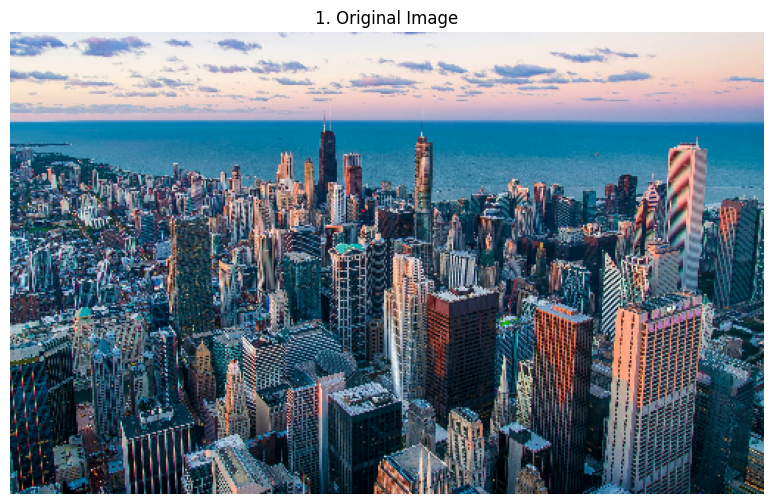

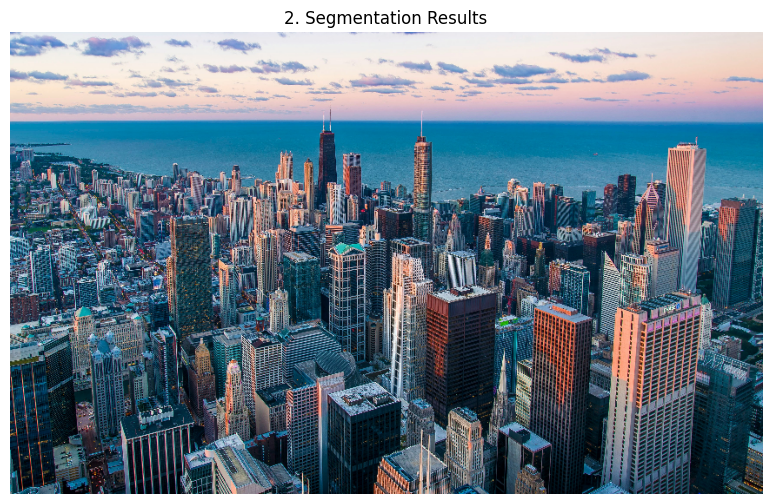

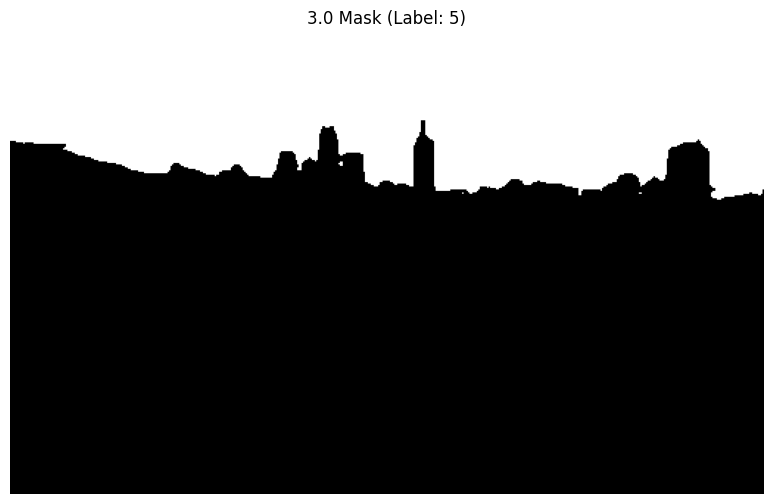

  0%|          | 0/15 [00:00<?, ?it/s]

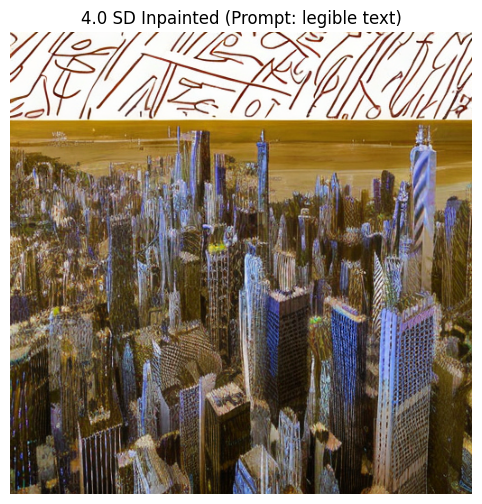

ValueError: operands could not be broadcast together with shapes (512,512,3) (314,512,1) 

In [ ]:
import cv2
import numpy as np
from PIL import Image

def load_and_prepare_mask(mask_path, target_image_shape):
    """Load a mask image and prepare it for inpainting pipeline"""
    # Load mask (grayscale)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise ValueError(f"Failed to load mask image: {mask_path}")

    # Resize to match target image dimensions
    mask = cv2.resize(mask, (target_image_shape[1], target_image_shape[0]),
                     interpolation=cv2.INTER_NEAREST)  # Preserve hard edges

    # Binarize (convert to 0s and 1s)
    mask_binary = (mask > 128).astype(np.uint8)

    # Format to match SAM's output structure
    return [{
        'segmentation': mask_binary,
        'area': int(np.sum(mask_binary)),
        'bbox': cv2.boundingRect(mask_binary)
    }]

def classify_masks_cpu(image, masks):
    # Use more accurate (but still efficient) model
    model = timm.create_model('tf_efficientnetv2_b0', pretrained=True)
    model.classifier = torch.nn.Linear(model.classifier.in_features, 8)
    model = model.to("cpu").eval()

    # Enhanced preprocessing
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
    ])

    labels = []
    for mask in masks:
        # Ensure mask matches image dimensions
        if mask['segmentation'].shape != image.shape[:2]:
            mask_resized = cv2.resize(mask['segmentation'],
                                    (image.shape[1], image.shape[0]),
                                    interpolation=cv2.INTER_NEAREST)
        else:
            mask_resized = mask['segmentation']

        # Apply mask and convert to PIL
        masked_img = image * mask_resized[..., np.newaxis]
        masked_img = Image.fromarray(masked_img.astype(np.uint8)).convert('RGB')

        # Classify
        input_tensor = preprocess(masked_img).unsqueeze(0).to("cpu")
        with torch.no_grad():
            output = model(input_tensor)
            labels.append(torch.argmax(output).item())

    return labels

# Example usage:
image_path = "input_img.jpg"
image = cv2.imread(image_path)
if image is None:
    raise ValueError(f"Failed to load image: {image_path}")

# Load and prepare your specific mask
masks = load_and_prepare_mask("4_112_mask.jpg", image.shape)

# Run the pipeline with your mask
output = run_pipeline_with_sd(image_path, masks, debug_mode=True)
cv2.imwrite("repaired_image_sd.jpg", output)

In [ ]:
# Run the pipeline
masks = "4_112_mask.jpg" #define mask hereeeeeeeeee
output = run_pipeline_with_sd("input_img.jpg", masks,debug_mode=True)
cv2.imwrite("repaired_image_sd.jpg", output)